In [1]:
import math
import cv2
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
import logging
%matplotlib notebook

In [15]:
IMAGE_PATH = "test.jpg"
PATCH_WIDTH = 512
PATCH_HEIGHT = 512
BORDER_TYPE="CONSTANT"

In [8]:
def create_patches_from_image(image_path, patch_width=256, patch_height=256, 
                              border_type="CONSTANT", return_array=True):
    """Create equally sized patches from an image by
       adding padding to the original image beforehand

    Args:
        n: the number to get the square root of.
    Returns:
        numpy array of image patches.
        height of the original image
        width of the original image
    Raises:
        ValueError: if image_path is not a file.
    """
    
    image_file = Path(image_path)
    if not image_file.is_file():
        raise ValueError("Image not found: {}.".format(image_path))
        
        
    img = cv2.imread(image_path)
    
    logging.info("Desired patch width: {}".format(patch_width))
    logging.info("Desired patch height: {}".format(patch_height))
    
    # Get height, width, channel information of the original image
    original_height, original_width, original_num_channels = img.shape
    logging.info(
        "Original image height: {}, Original image width: {}, Original number of channels {}"
        .format(original_height, original_width, original_num_channels))
    
    # Calculate the number of patches along the x- and y-axis
    number_patches_x = math.ceil(original_width / patch_width)
    number_patches_y = math.ceil(original_height / patch_height)
    total_number_patches = number_patches_x * number_patches_y
    logging.info("Number of patches along the x-axis: {}".format(number_patches_x))
    logging.info("Number of patches along the y-axis: {}".format(number_patches_y))
    logging.info("Total number of patches: {}".format(total_number_patches))
    
    # Calculate the dimensions of the resulting image with added padding
    scaled_image_width = number_patches_x * patch_width
    scaled_image_height = number_patches_y * patch_height
    logging.info("Scaled image height and width: {}, {}".format(scaled_image_height, scaled_image_width))

    # Calculate the width and height of the padding to add
    padding_width = scaled_image_width - original_width
    padding_height = scaled_image_height - original_height
    logging.info("Padding height and width: {}, {}".format(padding_height, padding_width))
    
    padded_image = add_padding_to_image(img, padding_width, padding_height, border_type=border_type)
        
    # Create a simple list of all patches
    image_patches = []
    for y in range(0,number_patches_y):
        for x in range(0,number_patches_x):
            logging.info("Y,X: {}, {}".format(y, x))
            crop_img = padded_image[(y*patch_height):(y*patch_height)+patch_height, (x*patch_width):(x*patch_width)+patch_width]
            image_patches.append(crop_img)
            
    # Transform the list into a numpy array
    patch_matrix = np.array(image_patches).reshape(number_patches_y, number_patches_x, patch_height, patch_width, original_num_channels)        
    
    logging.info("Generated number of image patches: {}".format(len(image_patches)))

    #print(image_patches[1].shape)
    #print(len(image_patches))
    #print(patch_matrix.shape)
    
    #plt.imshow(image_patches[1])
    #plt.title('cropped')
    #plt.show()


    #fig = plt.figure(figsize=(50, 50))  # width, height in inches

    #for i in range(len(image_patches)):
        #sub = fig.add_subplot(len(image_patches), 1, i + 1)
        #sub.imshow(image_patches[i], interpolation='nearest')
    
    return patch_matrix, original_height, original_width


def add_padding_to_image(image, padding_x, padding_y, border_type="CONSTANT"):
    """Takes an cv2 image and adds padding based on border_type to the right
       and bottom borders.
    Args:
        image: cv2 image.
        padding_x: padding along the x-axis
        padding_y: padding along the y-axis
        border_type: one of the values specified in BORDER_TYPE array
    Returns:
        image with added padding to the right and bottom borders
    Raises:
        ValueError: if image_path is not a file.
        ValueError: if border_type is not supported.
    """
    
    # Set the padding color to black
    PADDING_COLOR = [0,0,0]
    
    # Allowed border types
    BORDER_TYPE = [
        "CONSTANT",
        "REPLICATE",
        "REFLECT",
        "REFLECT_101",
        "WRAP"
    ]
    
    if border_type not in BORDER_TYPE:
        raise ValueError("Given BorderType {} is not supported.".format(border_type))
        
    # Python does not support switch/case out of the box
    # and I refuse to make it work with dictionaries!
    # See: https://docs.opencv.org/3.1.0/d3/df2/tutorial_py_basic_ops.html
    if border_type == 'CONSTANT':
        # copyMakeBorder(img,top, bottom, left, right,cv2.BORDER_TYPE)
        padded_image = cv2.copyMakeBorder(image,0,padding_y,0,padding_x,cv2.BORDER_CONSTANT,value=PADDING_COLOR)
    elif border_type == 'REPLICATE':
        padded_image = cv2.copyMakeBorder(image,0,padding_y,0,padding_x,cv2.BORDER_REPLICATE)
    elif border_type == 'REFLECT':
        padded_image = cv2.copyMakeBorder(image,0,padding_y,0,padding_x,cv2.BORDER_REFLECT)
    elif border_type == 'REFLECT_101':
        padded_image = cv2.copyMakeBorder(image,0,padding_y,0,padding_x,cv2.BORDER_REFLECT_101)
    elif border_type == 'WRAP':    
        padded_image = cv2.copyMakeBorder(image,0,padding_y,0,padding_x,cv2.BORDER_WRAP)
    else:
        raise ValueError("Something went wrong with the specified BorderType.")
        
    return padded_image    


def stitch_patches_to_image(patches, crop_height=None, crop_width=None):
    """Takes a numpy array of image patches and stitches them
       back together to one large image. If crop_height and crop_width
       is specified then the image get cropped accoring to these
       dimensions

    Args:
        patches: numpy array of images
        crop_height: resulting image height after cropping
        crop_width: resulting image width after cropping
    Returns:
        return image in form of a numpy array
    """

    number_patches_y, number_patches_x, patch_height, patch_width, original_num_channels = patches.shape  
    
    scaled_image_width = patch_width * number_patches_x
    scaled_image_height = patch_height * number_patches_y
    
    output_image = np.zeros((scaled_image_height,scaled_image_width,original_num_channels), dtype=np.uint8)
    
    for y in range(0,number_patches_y):
        for x in range(0,number_patches_x):
            output_image[(y*patch_height):(y*patch_height)+patch_height,(x*patch_width):(x*patch_width)+patch_width,:] = patches[y,x,:,:,:]
    
    if crop_height is not None and crop_width is not None:
        output_image = output_image[0:crop_height, 0:crop_width,:]

    return output_image

## Image Padding

The *add_padding_to_image* function is able to pad an image with five different
border types and adds the padding to the outer right and to the bottom of the original image. The CONSTANT border type is fixed to black.

The *create_patches_from_image* function is using the *add_padding_to_image* function under the hood and already loads an image_file for you if you specify the path. If you want to use the *add_padding_to_image* function in isolation then you have to manually load the image into an cv2 image like it is done below.

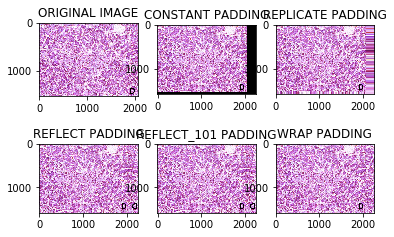

In [9]:
original_img = cv2.imread(IMAGE_PATH)
img_with_constant_padding = add_padding_to_image(original_img, 200, 50, border_type="CONSTANT")
img_with_replicate_padding = add_padding_to_image(original_img, 200, 50, border_type="REPLICATE")
img_with_reflect_padding = add_padding_to_image(original_img, 200, 50, border_type="REFLECT")
img_with_reflect_101_padding = add_padding_to_image(original_img, 200, 50, border_type="REFLECT_101")
img_with_wrap_padding = add_padding_to_image(original_img, 200, 50, border_type="WRAP")

plt.subplot(231),plt.imshow(original_img,'gray'),plt.title('ORIGINAL IMAGE')
plt.subplot(232),plt.imshow(img_with_constant_padding,'gray'),plt.title('CONSTANT PADDING')
plt.subplot(233),plt.imshow(img_with_replicate_padding,'gray'),plt.title('REPLICATE PADDING')
plt.subplot(234),plt.imshow(img_with_reflect_padding,'gray'),plt.title('REFLECT PADDING')
plt.subplot(235),plt.imshow(img_with_reflect_101_padding,'gray'),plt.title('REFLECT_101 PADDING')
plt.subplot(236),plt.imshow(img_with_wrap_padding,'gray'),plt.title('WRAP PADDING')

plt.show()
plt.gcf().clear()


## Create patches

The following code iterates the generated patches along the x-axis.

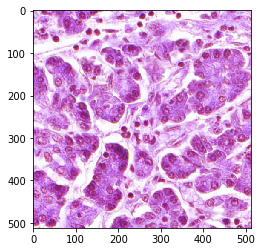

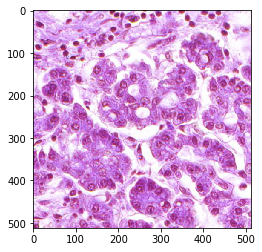

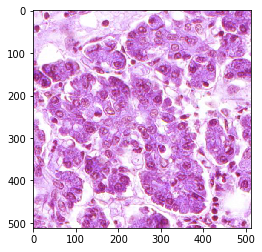

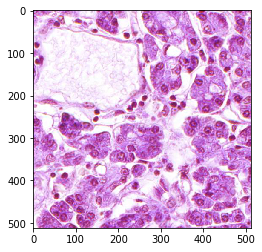

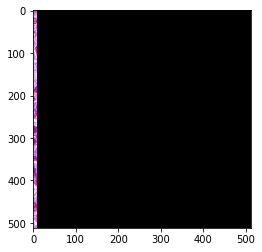

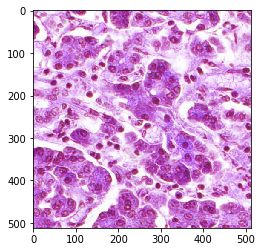

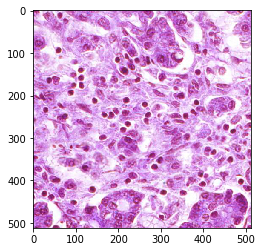

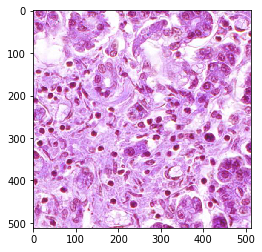

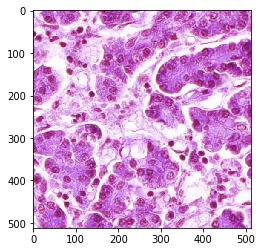

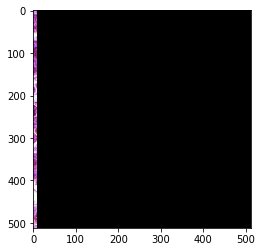

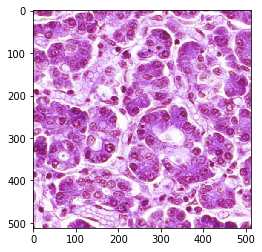

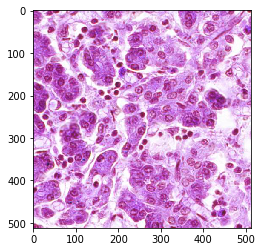

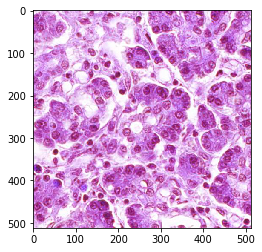

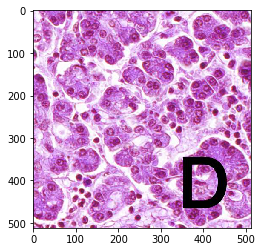

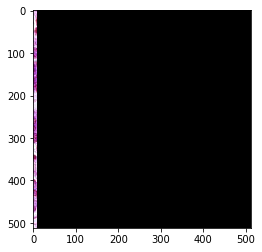

In [16]:
patches, original_height, original_width = create_patches_from_image(
    image_path=IMAGE_PATH, 
    patch_width=PATCH_WIDTH, 
    patch_height=PATCH_HEIGHT, 
    border_type=BORDER_TYPE)

row_count, column_count = (patches.shape[0:2])

# Show patches
for y in range(0,row_count):
    for x in range(0,column_count):
        plt.imshow(patches[y,x,:,:,:],'gray')
        plt.show()       
        
plt.gcf().clear()        

## Image stitching

The *stitch_patches_to_image* function needs the numpy array of image patches and the width and height of the image it should produce at the end. You probably want to give the original width and height of the image so that the padding gets removed during the cropping process. It's your responsibility to save the original dimensions of the image somewhere in order to make this function work. If you specify a width and height then these arguments are used for cropping otherwise nothing gets cropped and you receive an image with padding.

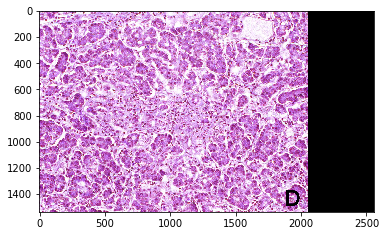

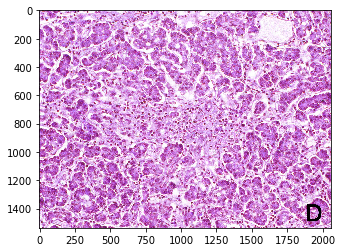

In [17]:
patches, original_height, original_width = create_patches_from_image(
    image_path=IMAGE_PATH, 
    patch_width=PATCH_WIDTH, 
    patch_height=PATCH_HEIGHT, 
    border_type=BORDER_TYPE)

output_with_padding = stitch_patches_to_image(patches)
output_without_padding = stitch_patches_to_image(patches, original_height, original_width)

plt.imshow(output_with_padding)
plt.show()

plt.imshow(output_without_padding)
plt.show()
        
plt.gcf().clear()        
    